In [14]:
import numpy as np

a = np.array([1, 2, 3])  # Create a rank 1 array
b = np.array([1, 2])
b=np.append(b,3)
print (type(a))            # Prints "<type 'numpy.ndarray'>"
print(a.dtype)
print (a.shape) 
result = np.dot( a, b)
print(result)

# Prints "(3,)"




<class 'numpy.ndarray'>
int32
(3,)
14


In [18]:
inputs=[1 ,3 ,5]
weights=[4 ,1 ,6]
bias=2
inputs=np.asarray(inputs)
weights=np.asarray(weights)
value=np.dot(np.append(inputs,1),np.append(weights,bias))
print(value)

39


In [19]:
class Neuron:
    def __init__(self, inbound_neurons=[]):
        # Neurons from which this Node receives values
        self.inbound_neurons = inbound_neurons
        # Neurons to which this Node passes values
        self.outbound_neurons = []
        # A calculated value
        self.value = None
        # Add this node as an outbound node on its inputs.
        for n in self.inbound_neurons:
            n.outbound_neurons.append(self)

    # These will be implemented in a subclass.
    def forward(self):
        """
        Forward propagation.

        Compute the output value based on `inbound_neurons` and
        store the result in self.value.
        """
        raise NotImplemented


class Input(Neuron):
    def __init__(self):
        # An Input Neuron has no inbound neurons,
        # so no need to pass anything to the Neuron instantiator
        Neuron.__init__(self)

        # NOTE: Input Neuron is the only Neuron where the value
        # may be passed as an argument to forward().
        #
        # All other Neuron implementations should get the value
        # of the previous neurons from self.inbound_neurons
        #
        # Example:
        # val0 = self.inbound_neurons[0].value
    def forward(self, value=None):
        # Overwrite the value if one is passed in.
        if value:
            self.value = value


In [25]:
weight_x= Input()
print(type(weight_x))
weight_x= 0.5
print(type(weight_x))



<class '__main__.Input'>
<class 'float'>


# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


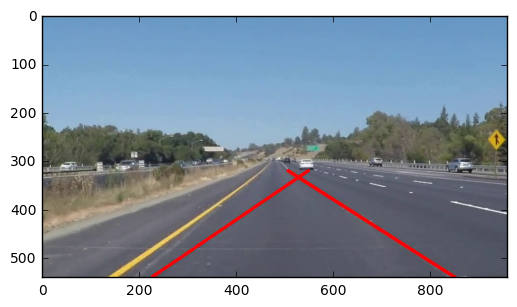

In [2]:
#reading in an image
#image = mpimg.imread('test_images/solidWhiteRight.jpg')
image = mpimg.imread('test_images/fjpg.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [59]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    print('type of lines',type(lines))
    print('dtype of lines',lines.dtype)
    print('lines',lines)
    
    leftline=[]
    rightline=[]
    
    leftcount=0
    rightcount=0
    
    
    for line in lines:
        for x1,y1,x2,y2 in line:                                  
            #print('line is',line)
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            if x1!=x2:                
                m=(y2-y1)/(x2-x1)                
                if m<-0.5:
                    leftline.extend(line)
                    leftcount=leftcount+1
                elif m>0.5:
                    rightline.extend(line)         
                    rightcount=rightcount+1
                
    
    
    #print('leftcount=',leftcount)
    #print('rightcount=',rightcount)
    lmean=np.mean(leftline, axis=0)
    
    rmean=np.mean(rightline, axis=0)
    #print()
    
    means=[lmean,rmean]
    #print('lmean',lmean)
    #print('rmean',rmean)
    """
    print('---------------------------------left line-------------------------------------')
    print('left line is',leftline)
    print('---------------------------------right line-------------------------------------')
    print('right line is',rightline)
    print('---------------------------------mean-------------------------------------')    
    print('left line mean is',lmean)
    print('right line mean is',rmean)
    print('mean is',means)
    """
    
    
    return means
            

def hough_lines(image_fordetecting_lines,color_image, rho, theta, threshold, min_line_len, max_line_gap):
    
    
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    
    lines = cv2.HoughLinesP(image_fordetecting_lines, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)    
    
    line_img = np.zeros((*image_fordetecting_lines.shape, 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    temp_img=np.copy(color_image)  
    
    mean=draw_lines(temp_img, lines)
    
    #print('type(mean)',type(mean))
    #print('mean',mean)
    #mean=np.around(mean)    
    mean=np.int32(mean)       
    
    igno=draw_lines(color_image, [mean])
    
    
    lx1=mean.item(0,0)
    ly1=mean.item(0,1)

    lx2=mean.item(0,2)
    ly2=mean.item(0,3)


    rx1=mean.item(1,0)
    ry1=mean.item(1,1)

    rx2=mean.item(1,2)
    ry2=mean.item(1,3)
    
    m1=(ly2-ly1)/(lx2-lx1)
    m2=(ry2-ry1)/(rx2-rx1)

    x1=lx1+ ((540-ly1)/(m1))
    x2=lx1+ ((320-ly1)/(m1))

    x3=rx1+ ((320-ry1)/(m2))
    x4=rx1+ ((540-ry1)/(m2))
    
    pointsfound=[[[x1 ,540,x2,320],[x3,320,x4,540]]]
    pointsfound=np.around(pointsfound)
    pointsfound=np.int32(pointsfound)
    draw_lines(color_image,pointsfound,color=[255, 0, 0], thickness=5)
 
    
    
    return color_image

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)   





[1 2]


list

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

run your solution on all test_images and make copies into the test_images directory).

In [60]:
import os
images=os.listdir("test_images/")

image = mpimg.imread('test_images/'+images[4])

#image=np.uint8(image) #image = image.astype(np.uint8) 
#image = (image * 255).round().astype(np.uint8) #print(image)
colorimage=image

i=0
#converting to gray scale
gray_img=grayscale(image)

#gaussian blurring the gray image
blur_img=gaussian_blur(gray_img,3) 
blur_img=gaussian_blur(blur_img,3) 


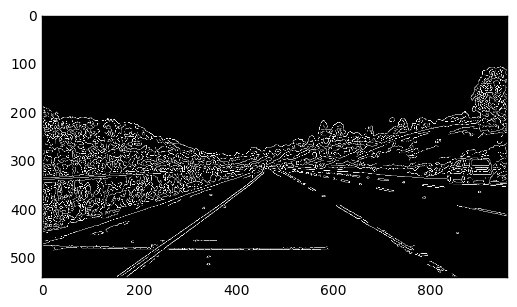

In [61]:
#canny edge detection on blurred image
canny_img=canny(blur_img,10,30)

i=i+1
plt.figure(i)
plt.imshow(canny_img,cmap='gray')


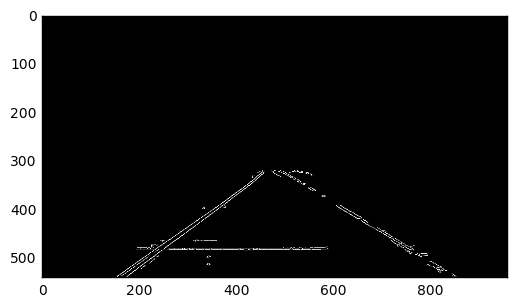

In [62]:

#masking region
vers=np.array([[100,canny_img.shape[0]],[450,320],[540,320],[canny_img.shape[1],canny_img.shape[0]]])#draw_lines(canny_img, vers)
#vers=np.array([ [100,canny_img.shape[0]],[450,320],[500,320] ,[150,canny_img.shape[0]], [canny_img.shape[1]-150,canny_img.shape[0]],[500,320],[540,320],[canny_img.shape[1],canny_img.shape[0]] ])#draw_lines(canny_img, vers)
#vers=np.array([ [100,canny_img.shape[0]],[450,340],[500,340] ,[150,canny_img.shape[0]], [canny_img.shape[1]-150,canny_img.shape[0]],[500,340],[540,340],[canny_img.shape[1],canny_img.shape[0]] ])#draw_lines(canny_img, vers)
#vers=np.array([ ])

            
masked_img=region_of_interest(canny_img, np.int32([vers]))

i=i+1
plt.figure(i)
plt.imshow(masked_img,cmap='gray')


type of lines <class 'numpy.ndarray'>
dtype of lines int32
lines [[[198 520 473 320]]

 [[217 480 763 480]]

 [[492 323 849 537]]

 [[154 538 454 328]]

 [[220 483 765 483]]

 [[485 321 848 539]]

 [[495 321 787 496]]

 [[176 522 456 326]]

 [[498 322 780 491]]

 [[345 411 428 350]]

 [[499 326 852 538]]

 [[196 479 253 479]]

 [[175 538 474 321]]

 [[193 482 590 482]]

 [[321 429 374 391]]

 [[244 464 359 464]]

 [[719 464 822 524]]

 [[393 375 440 340]]

 [[492 320 846 533]]

 [[751 488 820 526]]

 [[223 481 457 324]]

 [[238 484 761 484]]

 [[202 481 754 481]]

 [[520 321 556 328]]

 [[247 466 345 465]]

 [[532 478 754 485]]

 [[162 538 484 321]]

 [[448 322 548 324]]

 [[295 439 306 440]]

 [[489 322 826 525]]

 [[732 475 820 530]]

 [[330 398 453 324]]

 [[738 476 766 475]]

 [[528 339 788 495]]

 [[164 532 478 320]]

 [[204 522 476 324]]

 [[723 468 846 539]]

 [[183 522 481 321]]

 [[331 396 447 329]]

 [[205 522 231 503]]

 [[186 529 482 321]]

 [[479 326 491 333]]

 [[526 320 

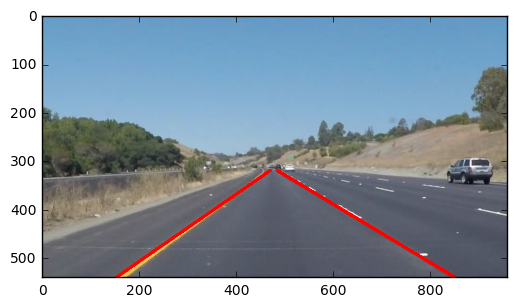

In [63]:
#Hough transform on masked region 

hough_image=hough_lines(masked_img,colorimage, 1, np.pi/180, 10, 5, 200)
#hough_lines(image_fordetecting_lines,color_image, rho, theta, threshold, min_line_len, max_line_gap):

i=i+1
plt.figure(i)
plt.imshow(hough_image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    colorimage=image

    i=0
    #converting to gray scale
    gray_img=grayscale(image)

    #gaussian blurring the gray image
    blur_img=gaussian_blur(gray_img,5) 
    


    #canny edge detection on blurred image
    #canny(img, low_threshold, high_threshold)
    canny_img=canny(blur_img,40,80)


    #masking region
    vers=np.array([[100,canny_img.shape[0]],[450,250],[540,250],[canny_img.shape[1],canny_img.shape[0]]])#draw_lines(canny_img, vers)
    vers=np.array([ [100,canny_img.shape[0]],[450,320],[500,320] ,[150,canny_img.shape[0]], [canny_img.shape[1]-150,canny_img.shape[0]],[500,340],[540,340],[canny_img.shape[1],canny_img.shape[0]] ])#draw_lines(canny_img, vers)

    masked_img=region_of_interest(canny_img, np.int32([vers]))

    #Hough transform on masked region 
    #hough_lines(image_fordetecting_lines,color_image, rho, theta, threshold, min_line_len, max_line_gap):
    hough_image=hough_lines(masked_img,colorimage, 1, np.pi/180, 30, 30, 200)
    
    
    return hough_image

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'yellow.mp4'
#clip1 = VideoFileClip("solidWhiteRight.mp4")
clip1 = VideoFileClip("solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


In [ ]:
"""The current algorithm may fail in case where the roads are curved.
So detecting arcs using hough transform 
is also a good way to make it more robust"""

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))